In [1]:
import argparse
import os
import shutil
import gzip

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch
import torch.nn as nn
from torch.autograd import Variable

from dpp_nets.utils.language import Vocabulary, BeerDataset, custom_collate
from dpp_nets.layers.layers import ChunkTrainer, ChunkTrainerRel

from dpp_nets.utils.language import EvalSet

In [2]:
from dpp_nets.utils.language import Vocabulary

embd_path = '/Users/Max/data/beer_reviews/review+wiki.filtered.200.txt.gz'
word_path = '/Users/Max/data/beer_reviews/reviews.all.train.words.txt.gz'

# Set-up Vocabulary
vocab = Vocabulary()
vocab.loadPretrained(embd_path)
vocab.setStops()
vocab.loadCorpus(word_path)
vocab.updateEmbedding()
vocab.setCuda(False)

In [109]:
# Load saved checkpoint
model = 'allwords1reg50.0reg_mean60.0lr0.001marginal_best_ckp.pth.tar'
model_dir = '/Users/Max/checkpoints/beer_reviews/marginal/' 
model_path = model_dir + model
model = torch.load(model_path, map_location=lambda storage, loc: storage)
vocab.EmbeddingBag.load_state_dict(model['embedding'])

In [110]:
EMBD_DIM = 200
KERNEL_DIM = 200
HIDDEN_DIM = 500
ENC_DIM = 200
TARGET_DIM = 3 if model['aspect'] in set(['all', 'short']) else 1

if model['mode'] == 'sents':
    trainer = ChunkTrainer(EMBD_DIM, HIDDEN_DIM, KERNEL_DIM, ENC_DIM, TARGET_DIM)
else:
    trainer = ChunkTrainerRel(EMBD_DIM, HIDDEN_DIM, KERNEL_DIM, ENC_DIM, TARGET_DIM)

trainer.load_state_dict(model['model'])
trainer.activation = nn.Sigmoid()
trainer.reg = model['reg']
trainer.reg_mean = model['reg_mean']

rat_path = '/Users/Max/data/beer_reviews/annotations.json'
evalset = EvalSet(rat_path, vocab)

In [111]:
# Plot a table
print('__________________________Training Table__________________________')
for k, v in model['train_loss'].items():
    epoch, loss, pred_loss, reg_loss = k, v[0], model['train_pred_loss'][k][0], model['train_reg_loss'][k][0]
    print(str.join(" | ", ['Epoch: %d' % (epoch), 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

__________________________Training Table__________________________
Epoch: 0 | Loss: 1.41367 | Pred Loss: 0.02558 | Reg Loss: 1.38809
Epoch: 1 | Loss: 0.08231 | Pred Loss: 0.02111 | Reg Loss: 0.06120
Epoch: 2 | Loss: 0.04986 | Pred Loss: 0.01894 | Reg Loss: 0.03092
Epoch: 3 | Loss: 0.03665 | Pred Loss: 0.01760 | Reg Loss: 0.01906
Epoch: 4 | Loss: 0.02893 | Pred Loss: 0.01625 | Reg Loss: 0.01268
Epoch: 5 | Loss: 0.02380 | Pred Loss: 0.01487 | Reg Loss: 0.00893


In [123]:
trainer.kernel_net.layer1.weight

Parameter containing:
-6.3479e-02  4.9515e-03  5.4917e-02  ...   9.1479e-02 -1.2858e-02 -3.6312e-02
-2.7782e-02 -9.2769e-02  2.7005e-02  ...   8.8775e-02 -6.7307e-03 -1.6314e-02
-1.5269e-02 -6.9123e-02 -6.6080e-02  ...  -1.2701e-04  1.0894e-02  1.8078e-02
                ...                   ⋱                   ...                
-7.7749e-02  2.7125e-02  1.0096e-02  ...   2.2767e-02  1.4063e-02 -2.1932e-02
 1.0105e-02 -5.9610e-02 -1.5147e-02  ...   1.7155e-03  1.4942e-02 -7.9904e-02
 6.2005e-02  8.5541e-02  7.8985e-02  ...   5.1885e-02 -4.0994e-02 -6.9273e-02
[torch.FloatTensor of size 500x400]

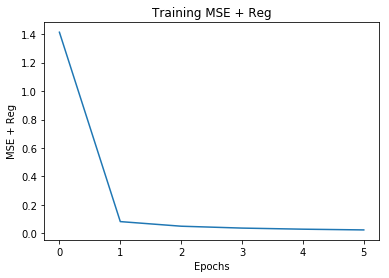

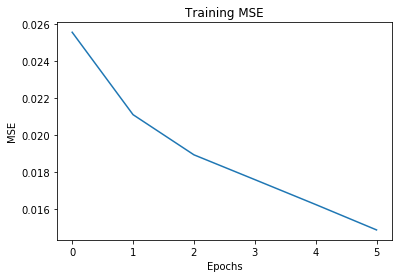

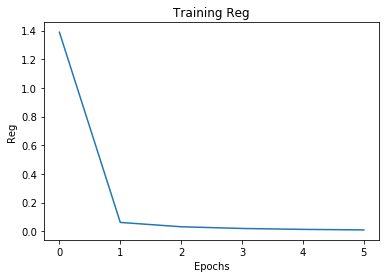

In [112]:
from dpp_nets.helper.plotting import plot_floats

# Training Plots
plot_floats(model['train_loss'], xlabel='Epochs', ylabel='MSE + Reg', title='Training MSE + Reg')
plot_floats(model['train_pred_loss'], xlabel='Epochs', ylabel='MSE', title='Training MSE')
plot_floats(model['train_reg_loss'], xlabel='Epochs', ylabel='Reg', title='Training Reg')

In [113]:
print('_________________________Validation Table_________________________')
for k, v in model['val_loss'].items():
    epoch, loss, pred_loss, reg_loss = k, v[0], model['val_pred_loss'][k][0], model['val_reg_loss'][k][0]
    print(str.join(" | ", ['Epoch: %d' % (epoch), 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

_________________________Validation Table_________________________
Epoch: 0 | Loss: 0.11890 | Pred Loss: 0.02278 | Reg Loss: 0.09611
Epoch: 1 | Loss: 0.06375 | Pred Loss: 0.02029 | Reg Loss: 0.04346
Epoch: 2 | Loss: 0.04786 | Pred Loss: 0.01945 | Reg Loss: 0.02841
Epoch: 3 | Loss: 0.03940 | Pred Loss: 0.01870 | Reg Loss: 0.02069
Epoch: 4 | Loss: 0.03464 | Pred Loss: 0.01858 | Reg Loss: 0.01606
Epoch: 5 | Loss: 0.03174 | Pred Loss: 0.01835 | Reg Loss: 0.01339


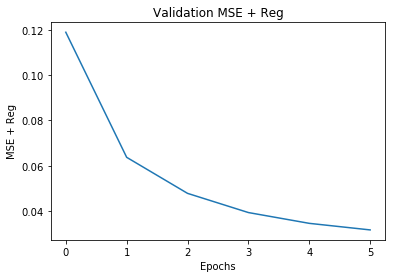

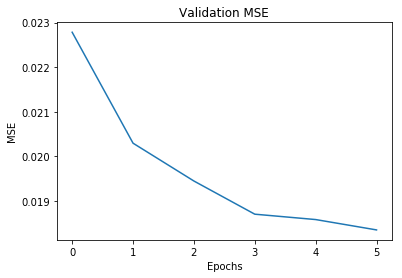

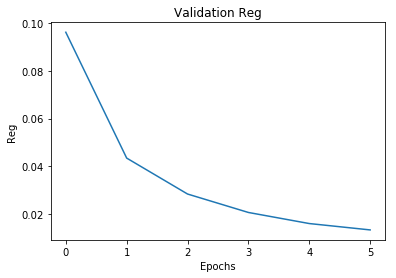

In [114]:
from dpp_nets.helper.plotting import plot_floats

# Training Plots
plot_floats(model['val_loss'], xlabel='Epochs', ylabel='MSE + Reg', title='Validation MSE + Reg')
plot_floats(model['val_pred_loss'], xlabel='Epochs', ylabel='MSE', title='Validation MSE')
plot_floats(model['val_reg_loss'], xlabel='Epochs', ylabel='Reg', title='Validation Reg')

In [115]:
# Evaluation on Test Set

loss, pred_loss, reg_loss = evalset.computeLoss(trainer, model['mode'])
print(str.join(" | ", ['Test Set:', 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

prec, extract = evalset.evaluatePrecision(trainer,model['mode'])
print(str.join(" | ", ['Test Set:', 'Precision: %.5f' % (prec), 'Extract: %.5f' % (extract)]))

Test Set: | Loss: 0.03083 | Pred Loss: 0.01270 | Reg Loss: 0.01813


/Users/Max/git/dpp_nets/dpp_nets/dpp/map.py:16: RuntimeWarning: invalid value encountered in subtract
  probs = [np.linalg.det(submat) - best_p for submat in submats]


Test Set: | Precision: 0.52975 | Extract: 0.25444


In [116]:
# Random Samples
evalset.sample(trainer, model['mode'],397)

index is: 397
('rather',) set() [('rather',)]
('also',) {'1'} [('also',)]
('date',) set() [('date',)]
('well',) {'1'} [('well',)]
('back',) {'1'} [('back',)]
('took',) set() [('took',)]
('case',) set() [('case',)]
('think',) set() [('think',)]
('start',) set() [('start',)]
('touch',) {'1'} [('touch',)]
('quickly',) set() [('quickly',)]
('somewhere',) {'1'} [('somewhere',)]
('initial',) {'1'} [('initial',)]
('section',) set() [('section',)]
('sharp',) {'1'} [('sharp',)]
('medium',) {'2'} [('medium',)]
('evident',) set() [('evident',)]
('head',) {'0'} [('head',)]
('discounted',) set() [('discounted',)]
('expected',) set() [('expected',)]
('offset',) {'2'} [('offset',)]
('clear',) {'0'} [('clear',)]
('finish',) set() [('finish',)]
('luscious',) {'2'} [('luscious',)]
("'s",) {'1'} [("'s",)]
('kick',) set() [('kick',)]
('reasonably',) set() [('reasonably',)]
('dark',) {'0'} [('dark',)]
('thickness',) {'2'} [('thickness',)]
('store',) set() [('store',)]
('potent',) set() [('potent',)]
('repo

In [117]:
# Random Marginals
evalset.computeMarginals(trainer, model['mode'],397)

index is: 397
0 0.936570193148 ('also',)
1 0.924661188658 ('date',)
2 0.913355227164 ('well',)
3 0.913192527238 ('back',)
4 0.906486741594 ('took',)
5 0.892033035616 ('think',)
6 0.889203663058 ('case',)
7 0.885110134078 ('rather',)
8 0.882042034171 ('start',)
9 0.875845902314 ('touch',)
10 0.863613810181 ('quickly',)
11 0.857946481395 ('initial',)
12 0.851617670371 ('somewhere',)
13 0.843171164885 ('section',)
14 0.813242450129 ('medium',)
15 0.811966583744 ('sharp',)
16 0.806880244426 ('evident',)
17 0.779508676452 ('head',)
18 0.753540181458 ('expected',)
19 0.750889028357 ('discounted',)
20 0.70816637514 ('clear',)
21 0.706786087215 ('offset',)
22 0.693340852715 ('finish',)
23 0.656604716773 ("'s",)
24 0.644509334685 ('kick',)
25 0.635253918743 ('dark',)
26 0.625970809312 ('luscious',)
27 0.62240670604 ('store',)
28 0.614378147106 ('reasonably',)
29 0.614259273629 ('thickness',)
30 0.589291492225 ('potent',)
31 0.588199067736 ('reported',)
32 0.567017410539 ('gamble',)
33 0.5628007

In [118]:
evalset.computeMAPPredLoss(trainer, model['mode'])

/Users/Max/git/dpp_nets/dpp_nets/dpp/map.py:16: RuntimeWarning: invalid value encountered in subtract
  probs = [np.linalg.det(submat) - best_p for submat in submats]


(0.020816871881409668, 0.2544413425130736)

In [122]:
[*range(3)]

[0, 1, 2]